In [1]:
from model import *
import pickle as pk
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
file_data = '..' + os.sep + 'data' + os.sep + 'meta_data' + os.sep + 'metadata_withmasks.csv'
image_folder = '..' + os.sep + 'images' + os.sep + 'img'
mask_folder = '..' + os.sep + 'images' + os.sep + 'mask'
file_features = '..' + os.sep + 'data' + os.sep + 'feature_data' + os.sep + 'feature_data.csv'

feature_names = ['mean_assymmetry', 'best_asymmetry', 'worst_asymmetry', 'red_var', \
    'green_var', 'blue_var', 'hue_var', 'sat_var', 'val_var', 'dom_hue', 'dom_sat', \
    'dom_val', 'compactness', 'convexity', 'F1', 'F2', 'F3', 'F10', 'F11', 'F12']

In [3]:
# Metadata
df = pd.read_csv(file_data)
df = df[df['mask'] == 1]

labels = df['diagnostic']

# Feature data
df_features = pd.read_csv(file_features)

In [4]:
# X and y
groups = df_features['patient_id']
X = df_features[feature_names]
y = (labels == 'BCC') | (labels == 'SCC') | (labels == 'MEL') 

In [6]:
accuracy_dict = {}
sensitivity_dict = {}
specificity_dict = {}
precision_dict = {}
roc_auc_dict = {}

for i in range(1,11):
    
    # PCA
    train_pca(X)
    X_transformed = apply_pca(X)
    
    # Feature selection
    train_feature_selector(X_transformed, y, i)
    X_transformed = apply_feature_selector(X_transformed)
    
    # Define classifiers
    classifiers = [KNeighborsClassifier(n_neighbors=i) for i in range(1, 10, 2)]

    # Cross Validate
    cv_results = cross_validate_clf(X_transformed, y, classifiers, groups)
    
    accuracy_max = 0
    clf_accuracy_max = None
    sensitivity_max = 0
    clf_sensitivity_max = None
    specificity_max = 0
    clf_specificity_max = None
    precision_max = 0
    clf_presision_max = None
    roc_auc_max = 0
    clf_roc_auc_max = None

    for clf, scores in cv_results.items():
        if scores['Accuracy'] > accuracy_max:
            accuracy_max = scores['Accuracy']
            clf_accuracy_max = clf
        if scores['Sensitivity'] > sensitivity_max:
            sensitivity_max = scores['Sensitivity']
            clf_sensitivity_max = clf
        if scores['Specificity'] > specificity_max:
            specificity_max = scores['Specificity']
            clf_specificity_max = clf
        if scores['Precision'] > precision_max:
            precision_max = scores['Precision']
            clf_precision_max = clf
        if scores['ROC AUC'] > roc_auc_max:
            roc_auc_max = scores['ROC AUC']
            clf_roc_auc_max = clf
    
    accuracy_dict[accuracy_max] = [i, clf_accuracy_max]
    sensitivity_dict[sensitivity_max] = [i, clf_sensitivity_max]
    specificity_dict[specificity_max] = [i, clf_specificity_max]
    precision_dict[precision_max] = [i, clf_precision_max]
    roc_auc_dict[roc_auc_max] = [i, clf_roc_auc_max]

In [7]:
results = pd.DataFrame(list(zip(accuracy_dict.keys(),sensitivity_dict.keys(),specificity_dict.keys(),precision_dict.keys(),roc_auc_dict.keys())),
                      columns = ['Accuracy','Sensitivity','Specificity','Precision','ROC_AUC'],
                      index=list(range(1,10)))

In [8]:
results

,Accuracy,Sensitivity,Specificity,Precision,ROC_AUC
1,0.705558,0.579336,0.782134,0.616566,0.680735
2,0.739338,0.618175,0.819863,0.677940,0.715517
3,0.765393,0.668100,0.824323,0.699160,0.746211
4,0.763869,0.695249,0.812421,0.687271,0.750360
5,0.733275,0.614103,0.826731,0.669588,0.703756
6,0.749291,0.625415,0.833789,0.685376,0.724937
7,0.718601,0.571267,0.821888,0.652606,0.685039
8,0.744922,0.567572,0.852394,0.700029,0.709983
9,0.733296,0.590422,0.838413,0.670892,0.705074


In [9]:
results.insert(0, 'k', list(range(1,10)))
results_ = results.melt('k', var_name = 'Metrics', value_name = 'Score')

<AxesSubplot:xlabel='k', ylabel='Score'>

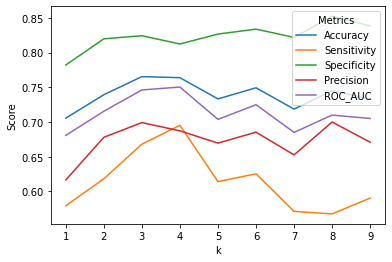

In [10]:
sns.lineplot(x='k', y='Score', hue='Metrics', data=results_)

In [11]:
print(f'Maximum accuracy score: {round(max(accuracy_dict),3)} (features: {accuracy_dict[max(accuracy_dict)][0]}, classifier: {accuracy_dict[max(accuracy_dict)][1]})')
print(f'Maximum sensitivity score: {round(max(sensitivity_dict),3)} (features: {sensitivity_dict[max(sensitivity_dict)][0]}, classifier: {sensitivity_dict[max(sensitivity_dict)][1]})')
print(f'Maximum specificity score: {round(max(specificity_dict),3)} (features: {specificity_dict[max(specificity_dict)][0]}, classifier: {specificity_dict[max(specificity_dict)][1]})')
print(f'Maximum precision score: {round(max(precision_dict),3)} (features: {precision_dict[max(precision_dict)][0]}, classifier: {precision_dict[max(precision_dict)][1]})')
print(f'Maximum roc auc score: {round(max(roc_auc_dict),3)} (features: {roc_auc_dict[max(roc_auc_dict)][0]}, classifier: {roc_auc_dict[max(roc_auc_dict)][1]})')

Maximum accuracy score: 0.765 (features: 3, classifier: KNeighborsClassifier with n_neighbors=9)
Maximum sensitivity score: 0.695 (features: 4, classifier: KNeighborsClassifier with n_neighbors=7)
Maximum specificity score: 0.852 (features: 8, classifier: KNeighborsClassifier with n_neighbors=9)
Maximum precision score: 0.7 (features: 8, classifier: KNeighborsClassifier with n_neighbors=9)
Maximum roc auc score: 0.75 (features: 4, classifier: KNeighborsClassifier with n_neighbors=7)


### Conclusion
* **Selct 4 best features**
* **KNeighborsClassifier with n_neighbors=7**

In [21]:
# PCA
train_pca(X) #saves pca.pcl
X_transformed = apply_pca(X)

# Feature selection
train_feature_selector(X_transformed, y, 4)
X_transformed = apply_feature_selector(X_transformed)

# Define classifiers
classifiers = [KNeighborsClassifier(n_neighbors=7)]

# Cross Validate
cv_results = cross_validate_clf(X_transformed, y, classifiers, groups)

In [22]:
cv_results

{'KNeighborsClassifier with n_neighbors=7': {'Accuracy': 0.7638692354123496,
  'Sensitivity': 0.6952488687782805,
  'Specificity': 0.8054719562243502,
  'Precision': 0.6872710594072823,
  'ROC AUC': 0.7503604125013154}}